In [26]:
import os
print(os.getcwd())
os.chdir('d:\\vscode_machineLearning\\internship\\Customer-Churn-Prediction')
print(os.getcwd())

d:\vscode_machineLearning\internship\Customer-Churn-Prediction
d:\vscode_machineLearning\internship\Customer-Churn-Prediction


## Entity

In [27]:
from dataclasses import dataclass
from pathlib import Path
import pickle

In [28]:
@dataclass(frozen=True)
class MLFlowTrackingConfig:
    mflow_dir : Path
    test_data: Path
    model_obj : str
    metrics_file: str
    params : dict
    mlflow_uri : str
    target_col : str
    confusion_metrics:str
    y_test_path: Path

    

## configuration 

In [29]:
from churnPredictor.utils import *
from churnPredictor.constants import *

In [30]:
class ConfigurationManager:
    def __init__(
        self,
        config_file_path = CONFIG_FILE_PATH,
        schema_file_path = SCHEMA_FILE_PATH,
        params_file_path=PARAMS_FILE_PATH):

        self.config = read_yaml(config_file_path)
        self.schema = read_yaml(schema_file_path)
        self.params = read_yaml(params_file_path)

        create_dirs([self.config.artifacts_root])

    def get_mlflow_tracking_config(self) -> MLFlowTrackingConfig:
        config = self.config.mlflow_tracking
        params = self.params.RandomForest
        schema = self.schema.DEPENDET_FEATURES

        # create_dirs([self.config.mflow_dir])

        return MLFlowTrackingConfig(
            mflow_dir=config.mlflow_dir,
            test_data=config.test_data,
            model_obj=config.model_obj_path,
            metrics_file=config.metrics_file_name,
            params=params,
            target_col=schema.Churn,
            mlflow_uri='https://dagshub.com/GyanPrakashKushwaha/Customer-Churn-Prediction.mlflow',
            confusion_metrics=config.confusion_metrics,
            y_test_path=config.y_test_path
        )

        

## component

In [31]:
from churnPredictor.components.model_trainer import ModelTrainer
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, classification_report
import pandas as pd
import joblib
import mlflow
from urllib.parse import urlparse
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:

from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier


class TrackModelPerformance:
    def __init__(self,config:MLFlowTrackingConfig):
        self.config = config

    def evaluate(self,true,pred):
        
        cm = confusion_matrix(true, pred)
        sns.heatmap(data=cm,annot=True, fmt='d', cmap='Blues')
        plt.savefig(self.config.confusion_metrics)
        accuracy = accuracy_score(true, pred)
        recall = recall_score(true, pred)
        precision = precision_score(true, pred)
        report = classification_report(true, pred)

        evaluation_report = {
                    'accuracy': accuracy,
                    'recall': recall,
                    'precision': precision,
                    # 'classification_report': report
                    }
        
        logger.info(f'evaluation_report -> {evaluation_report}')
        return evaluation_report 
    

    def start_mlflow(self):
        try:
            X_test = pd.read_csv(self.config.test_data)

            models = {
                    "GradientBoostingClassifier": GradientBoostingClassifier(),
                    "XGBoostClassifier": XGBClassifier(),
                    "CatBoostClassifier": CatBoostClassifier(),
                    "AdaBoostClassifier": AdaBoostClassifier(),
                    "RandomForestClassifier": RandomForestClassifier()
                }

            # for model_name in models.keys():
            #     model = joblib.load(open(file=os.path.join(r'artifacts\model',f'{model_name}.joblib'),mode='wb'))
            
            model = joblib.load(open(r'artifacts\model\AdaBoostClassifier.joblib','rb'))
            logger.info(f'{model} loaded')
            # X_test = test_data.drop('Churn',axis=1)

            y_test = pd.read_csv(self.config.y_test_path)
            mlflow.set_experiment('old')

            with mlflow.start_run():
                y_pred = model.predict(X_test)
                evaluation_report = self.evaluate(true=y_test,pred=y_pred)
                with open(self.config.metrics_file, 'w') as json_file:
                    json.dump(evaluation_report, json_file)
                if not self.config.params == None:
                    for param in self.config.params:
                        mlflow.log_param(param, self.config.params[param])
                # mlflow.log_params(self.config.params)

                for metric in evaluation_report:
                    mlflow.log_metric(metric,evaluation_report[metric])
                                
            # if tracking_url_type_store != 'file':
            #     mlflow.sklearn.log_model(model, 'model', registered_model_name="random forest")
            # else:
                mlflow.sklearn.log_model(model, self.config.model_obj)
        except Exception as e:
            raise CustomException(e)


[2023-09-17 04:41:22,943: INFO: utils: yaml file: config\config.yaml loaded successfully]
[2023-09-17 04:41:22,946: INFO: utils: yaml file: schema.yaml loaded successfully]
[2023-09-17 04:41:22,953: INFO: utils: yaml file: params.yaml loaded successfully]
[2023-09-17 04:41:22,954: INFO: utils: Created artifacts]
[2023-09-17 04:41:23,031: INFO: 34358935: AdaBoostClassifier(learning_rate=0.01, n_estimators=16) loaded]
[2023-09-17 04:41:23,954: INFO: 34358935: evaluation_report -> {'accuracy': 0.50565, 'recall': 0.07527965333064597, 'precision': 0.5123456790123457}]


d:\vscode_machineLearning\internship\Customer-Churn-Prediction\churnvenv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


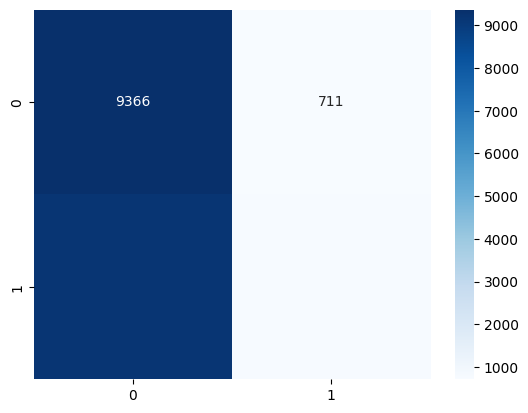

In [33]:
try:
    config = ConfigurationManager()
    mlflow_tracking_config = config.get_mlflow_tracking_config()
    track_model = TrackModelPerformance(config=mlflow_tracking_config)
    track_model.start_mlflow()
except Exception as e:
    raise CustomException(e)

## Old code.
```Python

class TrackModelPerformance:
    def __init__(self,config:MLFlowTrackingConfig):
        self.config = config

    def evaluate(self,true,pred):
        
        cm = confusion_matrix(true, pred)
        sns.heatmap(data=cm,annot=True, fmt='d', cmap='Blues')
        plt.savefig(self.config.confusion_metrics)
        accuracy = accuracy_score(true, pred)
        recall = recall_score(true, pred)
        precision = precision_score(true, pred)
        report = classification_report(true, pred)

        evaluation_report = {
                    'accuracy': accuracy,
                    'recall': recall,
                    'precision': precision,
                    # 'classification_report': report
                    }
        
        logger.info(f'evaluation_report -> {evaluation_report}')
        return evaluation_report 
    

    def create_experiment(self,experiment_name,run_name,model,metrics,confusion_matrix=None,params=None):
        try:            
            # mlflow.
            mlflow.set_registry_uri(self.config.mlflow_uri)
            self.tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            mlflow.set_experiment(experiment_name=experiment_name)
            with mlflow.start_run():

                if not params == None:
                    for i in params:
                        mlflow.log_param(i,params[i])

                for metric in metrics:
                    mlflow.log_metric(metric,metrics[metric])


                if not confusion_matrix == None:
                    mlflow.log_artifact(confusion_matrix,'confusion_matrix')
                
                mlflow.log_param('tree',params)
                mlflow.sklearn.log_model(model,self.config.model_obj)
                
                mlflow.set_tag("tag1", "Random Forest")
                mlflow.set_tags({"tag2":"basic model", "tag3":"experimentation"})

                logger.info('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))
        except Exception as e:
            raise CustomException(e)


    def start_mlflow(self):
        try:
            test_data = pd.read_csv(self.config.test_data)
            
            model = pickle.load(open(self.config.model_obj,'rb'))
            logger.info(f'{model} loaded')
            X_test = test_data.drop('Churn',axis=1)
            y_test = test_data['Churn']

            mlflow.set_registry_uri(self.config.mlflow_uri)
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            y_pred = model.predict(X_test)
            evaluation_report = self.evaluate(true=y_test,pred=y_pred)
            with open(self.config.metrics_file, 'w') as json_file:
                json.dump(evaluation_report, json_file)

            
            self.create_experiment(experiment_name='Random-Forest-clf',
                                run_name='experiment_1',
                                model=model,
                                metrics=evaluation_report,
                                params=self.config.params,
                                confusion_matrix=self.config.confusion_metrics)

            if tracking_url_type_store != 'file':
                mlflow.sklearn.log_model(model, self.config.model_obj, registered_model_name="random forest")
            else:
                mlflow.sklearn.log_model(model,  self.config.model_obj, registered_model_name="random forest")
        except Exception as e:
            raise CustomException(e)


```